## Evasion attack and poisoning attack on SVM

In [2]:
import secml
import secml.ml
import secml.ml.classifiers
import sklearn
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from secml.array import CArray
from secml.data import CDataset
from secml.ml.classifiers import CClassifierSVM, CClassifierKNN, CClassifierLogistic, CClassifierRidge
%matplotlib inline

In [3]:
from secml.ml.classifiers.sklearn.c_classifier_sklearn import CClassifierSkLearn

In [5]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1, n_classes=2)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0, n_samples=100),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

In [6]:
X, y = datasets[0]
h = .02

In [7]:
X = minmax_scale(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# # just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# # Plot the training points
# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#            edgecolors='k')
# # Plot the testing points
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
#            edgecolors='k')
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())
# plt.xticks(())
# plt.yticks(())

In [8]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [9]:
clf = SVC(C=1, kernel="rbf", gamma=1)
clf.fit(X_train, y_train)

SVC(C=1, gamma=1)

Text(0.5, 1.0, 'Moon Dataset (N=1000)')

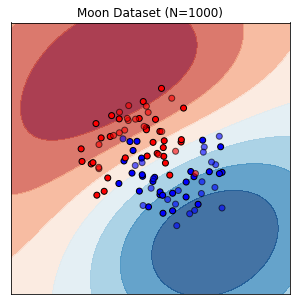

In [10]:
# score = clf.score(X_test, y_test)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize=(5,5))
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

# Plot the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
           edgecolors='k', alpha=0.6)
plt.xticks(())
plt.yticks(())
plt.title("Moon Dataset (N=1000)")
# ax.set_xlim(xx.min(), xx.max())
# ax.set_ylim(yy.min(), yy.max())
# ax.set_xticks(())
# ax.set_yticks(())
# if ds_cnt == 0:
#     ax.set_title(name)
# ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
#         size=15, horizontalalignment='right')

In [11]:
# clf = KNeighborsClassifier(3)
# clf.fit(X_train, y_train)

In [12]:
# clf = LogisticRegression()
# clf.fit(X_train, y_train)

### Evasion Attack

In [13]:
train = CDataset(X_train, y_train)
val = CDataset(X_test, y_test)

In [132]:
Cs = np.logspace(-2,2,4)

In [234]:
target_clf = CClassifierKNN(n_neighbors=1)
target_clf.fit(train.X, train.Y)
acc = metric.performance_score(y_true=val.Y, y_pred=target_clf.predict(val.X))

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 97.50%


In [244]:
clf = CClassifierSVM(C=1, kernel="rbf")
clf = clf.fit(train.X, train.Y)
acc = metric.performance_score(y_true=val.Y, y_pred=clf.predict(val.X))

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 87.50%


In [250]:
results = np.zeros((4, 10))
for k_idx, k in enumerate([1,10,25,50]):
    for d_idx, dmax in enumerate(np.arange(0.1, 1.1, 0.1)):
        target_clf = CClassifierKNN(n_neighbors=k)
        target_clf = target_clf.fit(train.X, train.Y)
        noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
        lb, ub = None, None  # Bounds of the attack space. Can be set to `None` for unbounded
        y_target = None  # None if `error-generic` or a class label for `error-specific`
        # Should be chosen depending on the optimization problem
        solver_params = {
            'eta': 0.3,
            'eta_min': 0.1,
            'eta_max': None,
            'max_iter': 100,
            'eps': 1e-4
        }

        pgd_ls_attack = CAttackEvasionPGDLS(
            classifier=clf,
            double_init_ds=train,
            distance=noise_type,
            dmax=dmax,
            lb=lb, ub=ub,
            solver_params=solver_params,
            y_target=y_target)
        eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(val.X, val.Y)
        results[k_idx, d_idx] = metric.performance_score(y_true=val.Y, y_pred=target_clf.predict(eva_adv_ds.X))
#     from secml.figure import CFigure
#     fig = CFigure(height=5, width=5)

#     # Convenience function for plotting the Security Evaluation Curve
#     fig.sp.plot_sec_eval(
#         sec_eval.sec_eval_data, marker='o', label='Logistic Regression', show_average=True)

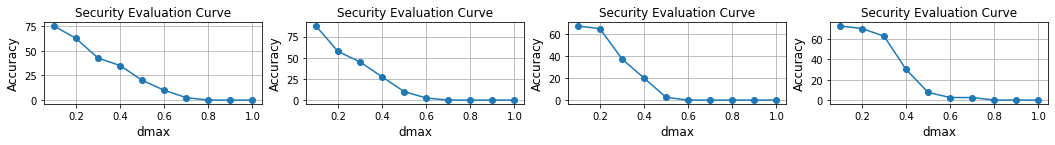

In [269]:
fig, axs = plt.subplots(1,4, figsize=(4.5*4, 1.5))
for i in range(4):
    ax = axs[i]
    ax.plot(np.arange(0.1, 1.1, 0.1), results[i]*100, marker="o")
    ax.set_title("Security Evaluation Curve")
    ax.set_ylabel("Accuracy",fontsize=12)
    ax.set_xlabel("dmax",fontsize=12)
    ax.grid(":")

In [276]:
np.diff(results, axis=1).mean(axis=1)*100

array([-8.333333, -9.722222, -7.5     , -8.055556])

In [277]:
np.diff(results, axis=1).std(axis=1)*100

array([ 6.454972,  9.891385,  9.860133, 10.914935])

In [142]:
eval_objs = [ ]
for C in Cs:
    clf = CClassifierSVM(C=C, kernel="rbf")
    clf = clf.fit(train.X, train.Y)
    noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
    dmax = 0.4  # Maximum perturbation
    lb, ub = None, None  # Bounds of the attack space. Can be set to `None` for unbounded
    y_target = None  # None if `error-generic` or a class label for `error-specific`
    # Should be chosen depending on the optimization problem
    solver_params = {
        'eta': 0.3,
        'eta_min': 0.1,
        'eta_max': None,
        'max_iter': 100,
        'eps': 1e-4
    }

    pgd_ls_attack = CAttackEvasionPGDLS(
        classifier=clf,
        double_init_ds=train,
        distance=noise_type,
        dmax=dmax,
        lb=lb, ub=ub,
        solver_params=solver_params,
        y_target=y_target)

    from secml.array import CArray
    e_vals = CArray.arange(start=0, step=0.1, stop=1.1)

    from secml.adv.seceval import CSecEval
    sec_eval = CSecEval(
        attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

    # Run the security evaluation using the test set
    print("Running security evaluation...")
    sec_eval.run_sec_eval(val)
    eval_objs.append(sec_eval)
#     from secml.figure import CFigure
#     fig = CFigure(height=5, width=5)

#     # Convenience function for plotting the Security Evaluation Curve
#     fig.sp.plot_sec_eval(
#         sec_eval.sec_eval_data, marker='o', label='Logistic Regression', show_average=True)

Running security evaluation...
Running security evaluation...
Running security evaluation...
Running security evaluation...
2021-05-11 16:49:28,818 - COptimizerPGDLS.0x12d58d7d0 - WARNING - Maximum iterations reached. Exiting.


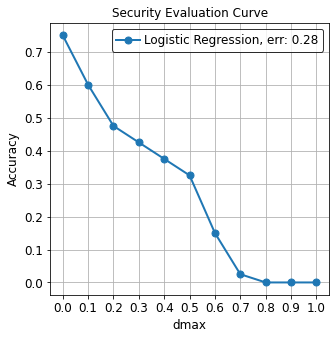

In [131]:
from secml.figure import CFigure
fig = CFigure(height=5, width=5)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    eval_objs[3].sec_eval_data, marker='o', label='Logistic Regression', show_average=True)

In [151]:
from secml.figure._plots.c_plot_sec_eval import _cmpt_sec_eval_curve
from secml.ml.peval.metrics import CMetric

In [199]:
def calculate_delta(sec_eval_data, metric="accuracy", metric_args=(), mean=True):
    metric = CMetric.create(metric, *metric_args)

    if not isinstance(sec_eval_data, list):
        sec_eval_data = [sec_eval_data]

    n_sec_eval = len(sec_eval_data)
    n_param_val = sec_eval_data[0].param_values.size
    perf = CArray.zeros((n_sec_eval, n_param_val))

    for i in range(n_sec_eval):
        if sec_eval_data[i].param_values.size != n_param_val:
            raise ValueError("the number of sec eval parameters changed!")

        perf[i, :] = _cmpt_sec_eval_curve(sec_eval_data[i], metric)

    if mean is True:
        perf_std = perf.std(axis=0, keepdims=False)
        perf = perf.mean(axis=0, keepdims=False)
    else:
        if len(sec_eval_data) > 1:
            raise ValueError("if `mean` is False, "
                             "only one sec eval data should be passed")

    perf = perf.ravel()
    diff = perf[:-1] - perf[1:]
    return diff.mean(), diff.std()

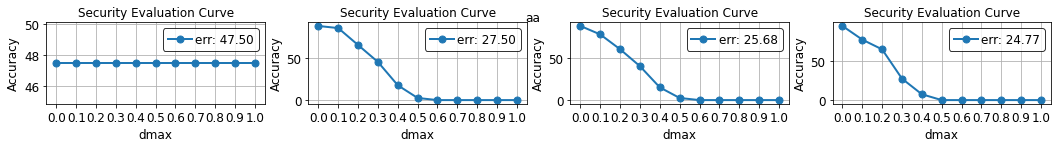

In [149]:
from secml.figure import CFigure
fig = CFigure(height=1.5, width=4.5*len(Cs))
fig.title("aa")
for idx in range(4):
    fig.subplot(1, 4, idx+1)
    # Convenience function for plotting the Security Evaluation Curve
    C = Cs[idx]
    fig.sp.plot_sec_eval(
        eval_objs[idx].sec_eval_data, marker='o', show_average=True, percentage=True)


In [200]:
for idx in range(4):
    print(calculate_delta(eval_objs[idx].sec_eval_data))

(0.0, 0.0)
(0.0875, 0.10139649895336625)
(0.0875, 0.09100137361600648)
(0.09499999999999999, 0.11926860441876563)


In [202]:
1/Cs

array([1.00000000e+02, 4.64158883e+00, 2.15443469e-01, 1.00000000e-02])

In [45]:
# clf = CClassifierLogistic()
# clf = clf.fit(train.X, train.Y)

In [47]:
from secml.adv.attacks.evasion import CAttackEvasion, CAttackEvasionPGDLS,  CAttackEvasionPGD

In [48]:
idx = 2
x0, y0 = train[idx, :].X, train[idx, :].Y  # Initial sample

In [49]:


# Run the evasion attack on x0
y_pred_pgdls, _, adv_ds_pgdls, _ = pgd_ls_attack.run(x0, y0)

In [50]:
print("Original x0 label: ", y0.item())
print("Adversarial example label (PGD-LS): ", y_pred_pgdls.item())

print("Number of classifier gradient evaluations: {:}"
      "".format(pgd_ls_attack.grad_eval))

Original x0 label:  1
Adversarial example label (PGD-LS):  0
Number of classifier gradient evaluations: 5


In [51]:
attack  = pgd_ls_attack
adv_ds  = adv_ds_pgdls

2021-05-11 15:55:45,847 - py.warnings - WARNING - /anaconda3/envs/secml/lib/python3.7/site-packages/secml/figure/_plots/c_plot.py:550: UserWarning: No contour levels were found within the data range.
  return self._sp.contour(x, y, z, *args, **kwargs)



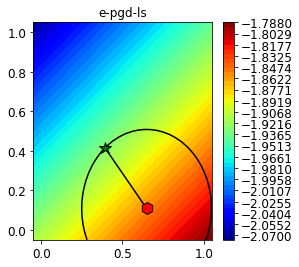

In [52]:
from secml.figure import CFigure
fig = CFigure(width=4, height=4, markersize=12)

# Let's replicate the `l2` constraint used by the attack for visualization
from secml.optim.constraints import CConstraintL2
constraint = CConstraintL2(center=x0, radius=dmax)

fig.sp.plot_fun(attack.objective_function, plot_levels=True,
                    multipoint=True, n_grid_points=200)
# Let's also plot the decision boundaries of the classifier
fig.sp.plot_decision_regions(clf, plot_background=False, n_grid_points=200)

# Construct an array with the original point and the adversarial example
adv_path = x0.append(adv_ds.X, axis=0)

# Convenience function for plotting the optimization sequence
fig.sp.plot_path(attack.x_seq)

# Convenience function for plotting a constraint
fig.sp.plot_constraint(constraint)

fig.sp.title(attack.class_type)
fig.sp.grid(grid_on=False)

Running security evaluation...


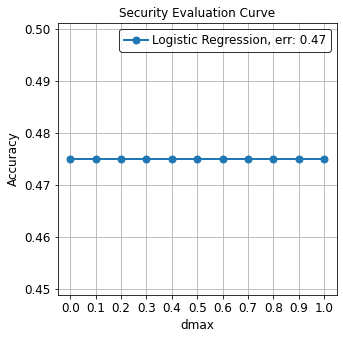

In [53]:
# Perturbation levels to test
from secml.array import CArray
e_vals = CArray.arange(start=0, step=0.1, stop=1.1)

from secml.adv.seceval import CSecEval
sec_eval = CSecEval(
    attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation...")
sec_eval.run_sec_eval(val)

from secml.figure import CFigure
fig = CFigure(height=5, width=5)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    sec_eval.sec_eval_data, marker='o', label='Logistic Regression', show_average=True)

In [ ]:

        n_sec_eval = len(sec_eval_data)
        n_param_val = sec_eval_data[0].param_values.size
        perf = CArray.zeros((n_sec_eval, n_param_val))

        for i in range(n_sec_eval):
            if sec_eval_data[i].param_values.size != n_param_val:
                raise ValueError("the number of sec eval parameters changed!")

            perf[i, :] = _cmpt_sec_eval_curve(sec_eval_data[i], metric)

        if mean is True:
            perf_std = perf.std(axis=0, keepdims=False)
            perf = perf.mean(axis=0, keepdims=False)
        else:
            if len(sec_eval_data) > 1:
                raise ValueError("if `mean` is False, "
                                 "only one sec eval data should be passed")

        perf = perf.ravel()

        if percentage is True:
            perf *= 100
            if mean is True:
                perf_std *= 100

In [65]:
sec_eval.sec_eval_data

CSecEvalData{'param_name': 'dmax', 'param_values': CArray(11,)(dense: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]), 'scores': [CArray(40, 2)(dense: [[ 0.992667 -0.992667] [ 0.991269 -0.991269] [ 0.983183 -0.983183] ... [ 0.936407 -0.936407] [ 0.994256 -0.994256] [ 0.992525 -0.992525]]), CArray(40, 2)(dense: [[ 0.983568 -0.983568] [ 0.98217  -0.98217 ] [ 0.974083 -0.974083] ... [ 0.945507 -0.945507] [ 0.985156 -0.985156] [ 0.983426 -0.983426]]), CArray(40, 2)(dense: [[ 0.974467 -0.974467] [ 0.973069 -0.973069] [ 0.964982 -0.964982] ... [ 0.954607 -0.954607] [ 0.976056 -0.976056] [ 0.974325 -0.974325]]), CArray(40, 2)(dense: [[ 0.965366 -0.965366] [ 0.963968 -0.963968] [ 0.955882 -0.955882] ... [ 0.963708 -0.963708] [ 0.966955 -0.966955] [ 0.965225 -0.965225]]), CArray(40, 2)(dense: [[ 0.956266 -0.956266] [ 0.954868 -0.954868] [ 0.946781 -0.946781] ... [ 0.972809 -0.972809] [ 0.957855 -0.957855] [ 0.956124 -0.956124]]), CArray(40, 2)(dense: [[ 0.947165 -0.947165] [ 0.945767 -0.945767] 

Running security evaluation...


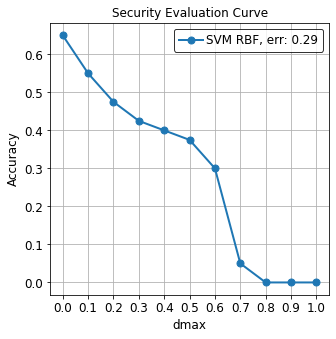

In [158]:
# Perturbation levels to test
from secml.array import CArray
e_vals = CArray.arange(start=0, step=0.1, stop=1.1)

from secml.adv.seceval import CSecEval
sec_eval = CSecEval(
    attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation...")
sec_eval.run_sec_eval(val)

from secml.figure import CFigure
fig = CFigure(height=5, width=5)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    sec_eval.sec_eval_data, marker='o', label='SVM RBF', show_average=True)

In [ ]:
sec_eval

### Poisoning attack

In [338]:
y_pred = clf.predict(val.X)

In [206]:
eval_objs = [ ]
for C in Cs:
    clf = CClassifierSVM(C=C, kernel="rbf")
    clf = clf.fit(train.X, train.Y)
    lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded
    n_poisoning_points = 20  # Number of poisoning points to generate

    # Should be chosen depending on the optimization problem
    solver_params = {
        'eta': 0.05,
        'eta_min': 0.05,
        'eta_max': None,
        'max_iter': 100,
        'eps': 1e-6
    }

    from secml.adv.attacks import CAttackPoisoningSVM
    pois_attack = CAttackPoisoningSVM(classifier=clf,
                                      training_data=train,
                                      val=val,
                                      lb=val.X.min(), ub=val.X.max(),
                                      solver_params=solver_params)
    pois_attack.n_points = n_poisoning_points

    # Run the poisoning attack
    # print("Attack started...")
    # pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(val.X, val.Y, max_iter=10)
    # print("Attack complete!")

    from secml.adv.seceval import CSecEval
    sec_eval = CSecEval(
        attack=pois_attack, param_name='dmax', param_values=e_vals)

    # Run the security evaluation using the test set
    print("Running security evaluation...")
    sec_eval.run_sec_eval(val)
    eval_objs.append(sec_eval)
#     from secml.figure import CFigure
#     fig = CFigure(height=5, width=5)

#     # Convenience function for plotting the Security Evaluation Curve
#     fig.sp.plot_sec_eval(
#         sec_eval.sec_eval_data, marker='o', label='SVM RBF', show_average=True)

    # Evaluate the accuracy of the original classifier
    # acc = metric.performance_score(y_true=val.Y, y_pred=y_pred)
    # # Evaluate the accuracy after the poisoning attack
    # pois_acc = metric.performance_score(y_true=val.Y, y_pred=pois_y_pred)

    # print("Original accuracy on test set: {:.2%}".format(acc))
    # print("Accuracy after attack on test set: {:.2%}".format(pois_acc))

Running security evaluation...
Running security evaluation...
Running security evaluation...
Running security evaluation...


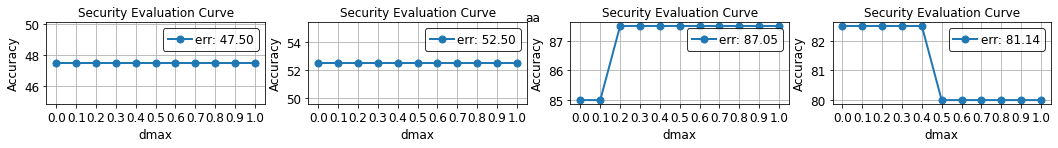

In [207]:
from secml.figure import CFigure
fig = CFigure(height=1.5, width=4.5*len(Cs))
fig.title("aa")
for idx in range(4):
    fig.subplot(1, 4, idx+1)
    # Convenience function for plotting the Security Evaluation Curve
    C = Cs[idx]
    fig.sp.plot_sec_eval(
        eval_objs[idx].sec_eval_data, marker='o', show_average=True, percentage=True)


In [208]:
for idx in range(4):
    print(calculate_delta(eval_objs[idx].sec_eval_data))

(0.0, 0.0)
(0.0, 0.0)
(-0.0025000000000000022, 0.007500000000000006)
(0.002499999999999991, 0.007499999999999974)


Initial poisoning sample features: CArray([0.862304 0.622573])
Initial poisoning sample label: 1


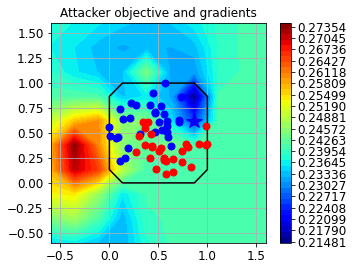

In [233]:
# chose and set the initial poisoning sample features and label
xc = train[3,:].X
yc = train[3,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc

print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.5, ub + 0.5),
                    (lb - 0.5, ub + 0.5)]

fig.sp.plot_ds(train)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(train[3,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')
fig.sp.plot_fun(
    func=pois_attack.objective_function,
    grid_limits=grid_limits, plot_levels=False,
    n_grid_points=10, colorbar=True)

# plot the box constraint
from secml.optim.constraints import CConstraintBox
box = fbox = CConstraintBox(lb=lb, ub=ub)
fig.sp.plot_constraint(box, grid_limits=grid_limits,
                       n_grid_points=10)

fig.tight_layout()
fig.show()

In [216]:
# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(val.X, val.Y, max_iter=10)
print("Attack complete!")

Attack started...
Attack complete!


In [222]:
y_pred = clf.predict(val.X)
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()
# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=val.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=val.Y, y_pred=pois_y_pred)

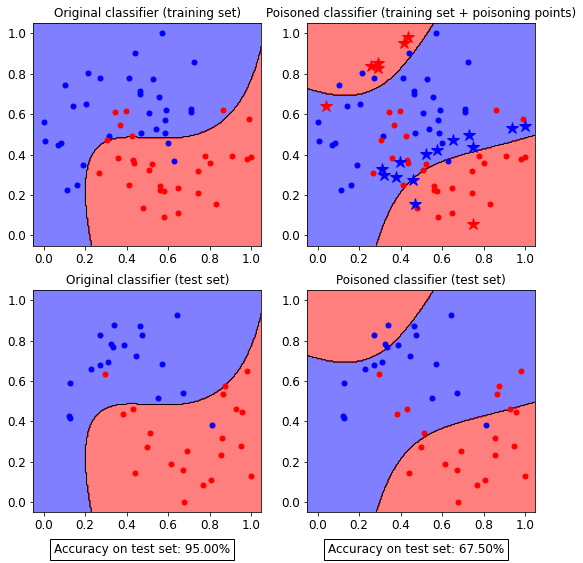

In [223]:
# Training of the poisoned classifier
pois_clf = clf.deepcopy()
pois_tr = train.append(pois_ds)  # Join the training set with the poisoning points
pois_clf.fit(pois_tr.X, pois_tr.Y)

# Define common bounds for the subplots
min_limit = min(pois_tr.X.min(), val.X.min())
max_limit = max(pois_tr.X.max(), val.X.max())
grid_limits = [[min_limit, max_limit], [min_limit, max_limit]]

from secml.figure import CFigure
fig = CFigure(9, 9)

fig.subplot(2, 2, 1)
fig.sp.title("Original classifier (training set)")
fig.sp.plot_decision_regions(
    clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(train, markersize=5)
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 2)
fig.sp.title("Poisoned classifier (training set + poisoning points)")
fig.sp.plot_decision_regions(
    pois_clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(train, markersize=5)
fig.sp.plot_ds(pois_ds, markers=['*', '*'], markersize=12)
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 3)
fig.sp.title("Original classifier (test set)")
fig.sp.plot_decision_regions(
    clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(val, markersize=5)
fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(acc),
            bbox=dict(facecolor='white'))
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 4)
fig.sp.title("Poisoned classifier (test set)")
fig.sp.plot_decision_regions(
    pois_clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(val, markersize=5)
fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(pois_acc),
            bbox=dict(facecolor='white'))
fig.sp.grid(grid_on=False)

fig.show()

In [ ]:
arget_clf_list = [
    CLF(
        clf_name='SVM Linear',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
        xval_parameters={'C': [1e-2, 0.1, 1]}),
    CLF(clf_name='SVM RBF',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='rbf'),
        xval_parameters={'C': [1e-2, 0.1, 1],  'kernel.gamma': [1, 10, 100]}),
    CLF(clf_name='Logistic (SGD)',
        clf=CClassifierMulticlassOVA(
            CClassifierSGD, regularizer='l2', loss='log',
            random_state=random_state),
        xval_parameters={'alpha': [1e-6, 1e-5, 1e-4]}),
    CLF(clf_name='kNN',
        clf=CClassifierKNN(),
        xval_parameters={'n_neighbors': [30, 40, 50]}),
    CLF(clf_name='Decision Tree',
        clf=CClassifierDecisionTree(random_state=random_state),
        xval_parameters={'max_depth': [1, 3, 5]}),
    CLF(clf_name='Random Forest',
        clf=CClassifierRandomForest(random_state=random_state),
        xval_parameters={'n_estimators': [20, 30, 40]}),
]